## Предсказание результатов игры

### Введение
 Это задание - финальный проект курса
Coursera [Введение в машинное обучение](https://www.coursera.org/learn/vvedenie-mashinnoe-obuchenie). На [Kaggle](https://kaggle.com/join/coursera_ml_dota2_contest) есть соотвествующее этому заданию соревнование.

 В данной работе с помощью методов машнного обучения *градиентного бустинга* и *логистической регресии* предсказывается результат игры Dota 2 по первым 5 минутам игры. 



In [1]:
#общие библиотеки работы с данными
import numpy as np
import pandas

#визуализация
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 

import time
import datetime

## Загрузка данных
 Данные для обучения и проверки находятся в файлах `features.csv` и `features_test.csv`. В качестве индексного поля используется индентификатор матча - `match_id`

In [2]:
train = pandas.read_csv('features.csv',index_col='match_id')

test = pandas.read_csv('features_test.csv',index_col='match_id')
#test = pandas.read_csv('test_items_bag.csv',index_col='match_id')

train.shape #Размер выборки для обучения

(97230, 108)

In [3]:
test.shape #Размер выборки для предсказания

(17177, 102)

In [4]:
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16,2449,0,4,1974,3,63


## Подготовка данных к обучению
### Удаление колонок с итоговыми данными
В исходной выборке присутствуют итоговые данные, название колонок с итоговыми данными объявлены в списке `resultColumns`

In [5]:
resultColumns = ['duration', 'radiant_win', 'tower_status_radiant',
                 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire']


Создадим новую выборку, без колоной с результатами матча, с помощью фунции `filter`

In [6]:
trainReduced=train[filter(lambda x: x not in resultColumns, train.columns)]

In [7]:
trainReduced.shape

(97230, 102)

In [8]:
test.shape

(17177, 102)

### Проверка данных на пропуски

In [9]:
colCounts = (97230 -  trainReduced.count())

In [10]:
colCounts[colCounts > 0]

first_blood_time               19553
first_blood_team               19553
first_blood_player1            19553
first_blood_player2            43987
radiant_bottle_time            15691
radiant_courier_time             692
radiant_flying_courier_time    27479
radiant_first_ward_time         1836
dire_bottle_time               16143
dire_courier_time                676
dire_flying_courier_time       26098
dire_first_ward_time            1826
dtype: int64

*Среди пропущенных данных, много полей которые относят к "первой крови"*. Это можно объяснить, тем что событие первая кровь не всегда наступает в первые 5 минут. Если первая кровь не наступила, то и другие данные связанные с этим событием отсуствуют.

Тем же (отсуствием события в первые 5 мин), обхясняется отсуствие полей `radiant_` , `dire_`

In [11]:
colCountsTest = (17177 -  test.count())
colCountsTest[colCountsTest > 0]

first_blood_time               3552
first_blood_team               3552
first_blood_player1            3552
first_blood_player2            7766
radiant_bottle_time            2895
radiant_courier_time            127
radiant_flying_courier_time    4885
radiant_first_ward_time         330
dire_bottle_time               2842
dire_courier_time               130
dire_flying_courier_time       4524
dire_first_ward_time            263
dtype: int64

### Заполнение пропущенных данных
Пропущенные данные заполняются нулями.

In [12]:
trainReduced=trainReduced.fillna(0)
test = test.fillna(0)

In [13]:
#Проверка пропусков после заполнения
colCounts = (trainReduced.count() - 97230 )
colCounts[colCounts < 0]

Series([], dtype: int64)

In [14]:
#Проверка пропусков после заполнения для тестовых данных
colCountsTest = (17177 -  test.count())
colCountsTest[colCountsTest > 0]

Series([], dtype: int64)

### Целевая переменная
Целевая перемнная содержится в колонке `radiant_win`

In [15]:
Y=train['radiant_win']
Y.shape

(97230,)

#### Модификация `GradientBoostingClassifier` и `LogisticRegression` для использования оценок с `predict_proba`


In [16]:
class GradientBoostingClassifier2(GradientBoostingClassifier):
    def predict(X):
        return GradientBoostingClassifier.predict_proba(self, X)
    
class LogisticRegression2(LogisticRegression):
    def predict(X):
        return LogisticRegression.predict_proba(self, X)

## Подход 1.  градиентный бустинг "в лоб"

### Выбор параметров обучения
Для подбора параметров обучения, проведем кросс валидацию для разного числа деревьев.

In [17]:
trainReduced.shape

(97230, 102)

In [18]:
trainRSample=trainReduced.sample(n=10000)

In [19]:
trainRSample.shape

(10000, 102)

In [20]:
trainRSample.index

Int64Index([ 46355,  58109,  87306,  99282,  73245,  97237,  49527, 104399,
             28609,  24673,
            ...
             23503,  42826,  38027,  13351,  97547,  70076,  23257,  43413,
             25014,  29944],
           dtype='int64', name=u'match_id', length=10000)

In [21]:
YSample=Y.ix[trainRSample.index]

In [22]:
YSample.shape

(10000,)

In [23]:
#from sklearn.neural_network import MLPClassifier

### Улучшение качества при изменении кол-ва деревьев

In [24]:
def plotAll(roc_auc,time_elapsed,par):
    timesElapsed1Sec = [ x.total_seconds() for x in time_elapsed ]
    fig=plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(par,roc_auc, 'ro-')
    #ax1.set_xlabel('number of trees')
    ax1.set_ylabel('ROC AUC value')
    ax2 = ax1.twinx()
    ax2.plot(par,timesElapsed1Sec, 'g.-')
    ax2.set_ylabel('Elapsed time, s')
    plt.show

plotAll(roc_auc1,timesElapsed1,numOfTrees)

Как видно из графика, рост сткорости качества ROC AUC замедляется, а время необходимое для вычислений растет.
Однако, рост качества при увеличении количества деревьев продалажается.

## Подход 2. логистическая регрессия


### Масштабирование признаков

In [25]:
# Scale data
standard_scaler = StandardScaler()
Xtr_s = standard_scaler.fit_transform(trainReduced)
#Xte_s = standard_scaler.transform(X_test)

In [26]:
def optimize_reg(X,Y, C_xrange):
    roc_auc2=[]
    Coeff2=[]
    timesElapsed2=[]
    for i in C_xrange:    
        start_time = datetime.datetime.now()
        scores = cross_val_score(LogisticRegression2(C=i,penalty='l2',random_state=1, n_jobs=-1),
                            X, Y, cv=KFold(len(X),
                            n_folds=5, shuffle=True, random_state=241),scoring='roc_auc')
        timeElapsed = datetime.datetime.now() - start_time
        timesElapsed2.append(timeElapsed)
        roc_auc2.append(scores.mean())
        Coeff2.append(i)
        print 'i %f  score %f, time elapsed:%s' % (i, scores.mean(),timeElapsed)
    return [roc_auc2,Coeff2,timesElapsed2]      

[roc_auc2,Coeff2,timesElapsed2] = optimize_reg(Xtr_s, Y, np.arange(0.001,0.01,0.001))

plotAll(roc_auc2,timesElapsed2,Coeff2)

### Исключение из выборки категориальных признаков

In [27]:
catFeatures = ['lobby_type', 'r1_hero','r2_hero','r3_hero','r4_hero',
              'r5_hero','d1_hero','d2_hero','d3_hero','d4_hero','d5_hero']

In [28]:
trainReduced2=trainReduced[filter(lambda x: x not in catFeatures, trainReduced.columns)]
testReduced2=test[filter(lambda x: x not in catFeatures, test.columns)]

standard_scaler2 = StandardScaler()
Xtr_s2 = standard_scaler2.fit_transform(trainReduced2)
Xts_s2 = standard_scaler2.transform(testReduced2)
trainReduced2.shape

(97230, 91)

In [29]:
testReduced2.shape

(17177, 91)

[roc_auc3,Coeff3,timesElapsed3] = optimize_reg(Xtr_s2, Y, np.arange(0.001,0.01,0.001))

plotAll(roc_auc3,timesElapsed3,Coeff3)

### Результат исключения категориальных признаков
После исключения категориальных признаков, результат стал лучше, ROC AUC был: 

|#|До исключения|После|
|---|---|---|
|ROC_AUC|0.716360|0.716414|

### Формирование "мешка слов"

In [30]:
catFeatures2 = ['r1_hero','r2_hero','r3_hero','r4_hero',
              'r5_hero','d1_hero','d2_hero','d3_hero','d4_hero','d5_hero']

Найдем количество уникальных героев

In [31]:
heros = pandas.Series(trainReduced[catFeatures2].values.ravel()).unique()
heros

array([ 11,  67,  29,  20, 105,   4,  42,  21,  37,  84,  49,  26,  39,
        88,  79,   7,  12,  33,  98,  27,  22,  66,  86,  80,  30,  75,
        41,  96,  48,  15, 102,  13,  72,  93,  69,  25,   8,  28,  65,
        55,  52,   3,  73,  57,  36, 101,  47,  35,  83, 100,  44,  17,
        91,  53,  90,  19,  74,  76,  99,   1,  94,  82,  60, 112,  31,
        85,  61,  70,  68,  51,   2,  50,  71,  23,  77,  16,  63,  92,
        81,  18,  59,  95,  64,  58,  43, 104,  40,  87,  10,  14, 110,
        38,  46,  54,  97,  89,   5,  62,   6,  78, 106,  34,  56, 103,
       109,  45,   9,  32])

In [32]:
S=heros.shape
N=S[0]
N

108

In [33]:

max(heros)

112

In [34]:
herosTest = pandas.Series(test[catFeatures2].values.ravel()).unique()
max(herosTest)

112

Проверим, совпадают ли списки герои в тренировочной и тестовой выборке

In [35]:
list(set(heros) - set(herosTest))

[]

In [36]:
list(set(herosTest) - set(heros))

[]

In [37]:
## Функция формирования мешка слов из задания
def gen_bag(data,maxHeros):
    X_pick = np.zeros((data.shape[0], maxHeros+1))
    X_pick_columns = [];

    for i, match_id in enumerate(data.index):
        for p in xrange(5):
            X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]] = 1
            X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]] = -1
    return X_pick

In [38]:
#Сформируем матрицы со словами
X_pick = gen_bag(trainReduced, max(heros))
X_pick_test = gen_bag(test,max(heros))

In [39]:
X_pick_columns =[]
for i in range(1,114):
    X_pick_columns.append('r%d_hero' % i)

In [40]:
len(X_pick_columns)

113

In [41]:
X_pick_test.shape

(17177, 113)

In [42]:
X_pick.shape

(97230, 113)

In [43]:
Xts_s2.shape

(17177, 91)

### Приклеиваем категориальные признаки героев

In [44]:
#Склеиваем матрицу с масшатбированной матрицей без категориальных признаков
X_concat = np.hstack((trainReduced2,X_pick))
X_concat_test = np.hstack((testReduced2,X_pick_test))

In [45]:
X_concat.shape

(97230, 204)

X_concat_test.shape

[roc_auc4,Coeff4,timesElapsed4] = optimize_reg(X_concat, Y, np.arange(0.005,0.1,0.005))

plotAll(roc_auc4,timesElapsed4,Coeff4)

max(roc_auc4)

C_opt = Coeff4[roc_auc4.index(max(roc_auc4))]
C_opt
#0.049999999999999996

### Оптимальная модель

Как видно из результата кросс-валидации качество модели улучшилось. 

|Метод| ROC_AUC|
|---|---|---|
| только масштабированная|0.716360|
|+ без категориальных признаков|0.716414|
|+ "мешок слов"|0.751944|
|+ "мешок слов комната"|0.752097|
|+ "нелиненые параметры"|0.7524|



#### Максимальное и минимальное качество на тестовой модели

Таким образом, разница между минимальным и максимальным качеством на тестовой выборке для оптимального алгоритма 0.7%

In [46]:
test['lobby_type'].value_counts()

1    9857
7    5029
0    2291
Name: lobby_type, dtype: int64

In [47]:
## Функция формирования мешка слов из задания
def gen_bag2(data,maxLobbies):
    X_pick = np.zeros((data.shape[0], maxLobbies+1))

    for i, match_id in enumerate(data.index):
        for p in xrange(3):
            X_pick[i, data.ix[match_id, 'lobby_type']] = 1
    return X_pick

In [48]:
X_pick2 = gen_bag2(trainReduced,7)
X_pick2_test = gen_bag2(test,7)

In [49]:
X_pick2.shape

(97230, 8)

In [50]:
X_pick3 = np.delete(X_pick2,[2,3,4,5,6],1)
X_pick3_test = np.delete(X_pick2_test,[2,3,4,5,6],1)

In [51]:
X_pick3.shape

(97230, 3)

In [52]:
X_pick2_columns = ['lobby_type_0', 'lobby_type_1', 'lobby_type_7']

###  Приклеиваем тип комнаты

In [53]:
X_concat = np.hstack((X_concat,X_pick3))
X_concat_test = np.hstack((X_concat_test,X_pick3_test))

In [54]:
scores2 = cross_val_score(LogisticRegression2(C=0.049999999999999996,penalty='l2',random_state=1, n_jobs=-1),
                            X_concat, Y, cv=KFold(len(X_concat),
                            n_folds=5, shuffle=True, random_state=241),scoring='roc_auc')

In [55]:
scores2.max()

0.516677350142284

## Предсказание на тестовых данных

X_concat_test.shape

X_concat.shape

Y_pred = clf.predict_proba(X_concat_test)[:, 1]

### Предсказание с учетом комнаты

In [56]:
standard_scaler3 = StandardScaler()
X_concat = standard_scaler2.fit_transform(X_concat)
X_concat_test = standard_scaler2.transform(X_concat_test)

In [57]:
clf2=LogisticRegression(C=0.005,penalty='l2',random_state=1, n_jobs=-1)
clf2.fit(X_concat,Y)

LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

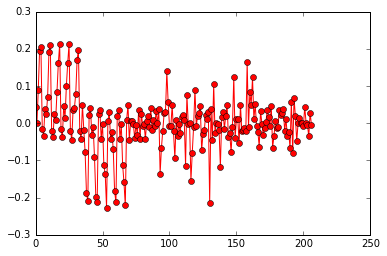

In [58]:
# Резльтирующие коэффициенты логистической регрессии
plt.plot(clf2.coef_[0],'ro-')

## Анализируем какие из коэффициентов имеют больший вес

In [59]:
clf2.coef_[0].shape

(207,)

In [60]:
allColumns = list(trainReduced2.columns.values) + X_pick_columns + X_pick2_columns

In [61]:
len(allColumns)

207

In [62]:
import mpld3

mpld3.enable_notebook()
fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))

somefig=ax.plot(clf2.coef_[0],'ro-')
#x=range(len(allColumns))
#plt.xticks(clf2.coef_[0],allColumns, rotation='vertical')

#labels = ['point {0}'.format(i + 1) for i in range(N)]
tooltip = mpld3.plugins.PointLabelTooltip(somefig[0], labels=allColumns)
mpld3.plugins.connect(fig, tooltip)
mpld3.display()

In [63]:
scores2 = cross_val_score(LogisticRegression2(C=0.005,penalty='l2',random_state=1, n_jobs=-1),
                            X_concat, Y, cv=KFold(len(X_concat),
                            n_folds=5, shuffle=True, random_state=241),scoring='roc_auc')
scores2.mean()


0.75213195753995232

In [107]:
Reduced4train = pandas.DataFrame(X_concat,columns=allColumns)
Reduced4train.shape

(97230, 207)

In [108]:
Reduced4test = pandas.DataFrame(X_concat_test,columns=allColumns)
Reduced4test.shape

(17177, 207)

In [109]:
mostImportantColumnsR = ['r1_lh','r2_lh','r3_lh','r4_lh','r5_lh']
mostImportantColumnsD = ['d1_lh','d2_lh','d3_lh','d4_lh','d5_lh']
mostImportantHerosR = ['r8_hero','r23_hero','r43_hero','r58_hero','r68_hero']
mostImportantHerosD = ['r3_hero','r26_hero','r40_hero','r48_hero']
GoldR=['r1_gold','r2_gold','r3_gold','r4_gold','r5_gold']
GoldD=['d1_gold','d2_gold','d3_gold','d4_gold','d5_gold']
XpR=['r1_xp','r2_xp','r3_xp','r4_xp','r5_xp']
XpD=['d1_xp','d2_xp','d3_xp','d4_xp','d5_xp']

In [110]:
#Reduced4train['cumKillsR']=Reduced4train[mostImportantColumnsR].sum(axis=1)**2
#Reduced4train['cumKillsD']=Reduced4train[mostImportantColumnsD].sum(axis=1)**2
Reduced4train['cumKillsRD_D2']=(Reduced4train[mostImportantColumnsR].sum(axis=1)-Reduced4train[mostImportantColumnsD].sum(axis=1))**2

#Reduced4train['cumKillsR_L']=Reduced4train[mostImportantColumnsR].sum(axis=1)
#Reduced4train['cumKillsD_L']=Reduced4train[mostImportantColumnsD].sum(axis=1)
Reduced4train['cumKillsRD_LD']=Reduced4train[mostImportantColumnsR].sum(axis=1)-Reduced4train[mostImportantColumnsD].sum(axis=1)

#Reduced4train['herR']=Reduced4train[mostImportantHerosR].sum(axis=1)**2
#Reduced4train['herD']=Reduced4train[mostImportantHerosD].sum(axis=1)**2

#Reduced4train['GoldR']=Reduced4train[XpR].sum(axis=1)**2
#Reduced4train['GoldD']=Reduced4train[XpD].sum(axis=1)**2
Reduced4train['GoldRD_D2']=(Reduced4train[XpR].sum(axis=1)-Reduced4train[XpD].sum(axis=1))**2

#Reduced4train['GoldR_L']=Reduced4train[XpR].sum(axis=1)
#Reduced4train['GoldD_L']=Reduced4train[XpD].sum(axis=1)
Reduced4train['GoldRD_D']=Reduced4train[XpR].sum(axis=1)-Reduced4train[XpD].sum(axis=1)

#Reduced4train['XpR']=Reduced4train[GoldR].sum(axis=1)**2
#Reduced4train['XpD']=Reduced4train[GoldD].sum(axis=1)**2
Reduced4train['XpRD_D2']=(Reduced4train[GoldR].sum(axis=1)-Reduced4train[GoldD].sum(axis=1))**2

#Reduced4train['XpR_L']=Reduced4train[GoldR].sum(axis=1)
#Reduced4train['XpD_L']=Reduced4train[GoldD].sum(axis=1)
Reduced4train['XpRD_LD']=Reduced4train[GoldR].sum(axis=1)-Reduced4train[GoldD].sum(axis=1)

#Reduced4test['cumKillsR']=Reduced4test[mostImportantColumnsR].sum(axis=1)**2
#Reduced4test['cumKillsD']=Reduced4test[mostImportantColumnsD].sum(axis=1)**2
Reduced4test['cumKillsRD_D2']=(Reduced4test[mostImportantColumnsR].sum(axis=1)-Reduced4test[mostImportantColumnsD].sum(axis=1))**2


#Reduced4test['cumKillsR_L']=Reduced4test[mostImportantColumnsR].sum(axis=1)
#Reduced4test['cumKillsD_L']=Reduced4test[mostImportantColumnsD].sum(axis=1)
Reduced4test['cumKillsRD_D']=Reduced4test[mostImportantColumnsR].sum(axis=1)-Reduced4test[mostImportantColumnsD].sum(axis=1)

#Reduced4test['herR']=Reduced4test[mostImportantHerosR].sum(axis=1)**2
#Reduced4test['herD']=Reduced4test[mostImportantHerosD].sum(axis=1)**2

#Reduced4test['GoldR']=Reduced4test[XpR].sum(axis=1)**2
#Reduced4test['GoldD']=Reduced4test[XpD].sum(axis=1)**2
Reduced4test['GoldRD_D2']=(Reduced4test[XpR].sum(axis=1)-Reduced4test[XpD].sum(axis=1))**2

#Reduced4test['GoldR_L']=Reduced4test[XpR].sum(axis=1)
#Reduced4test['GoldD_L']=Reduced4test[XpD].sum(axis=1)
Reduced4test['GoldRD_D']=Reduced4test[XpR].sum(axis=1)-Reduced4test[XpD].sum(axis=1)

#Reduced4test['XpR']=Reduced4test[GoldR].sum(axis=1)**2
#Reduced4test['XpD']=Reduced4test[GoldD].sum(axis=1)**2
Reduced4test['XpRD_D2']=(Reduced4test[GoldR].sum(axis=1)-Reduced4test[GoldD].sum(axis=1))**2

#Reduced4test['XpR_L']=Reduced4test[GoldR].sum(axis=1)
#Reduced4test['XpD_L']=Reduced4test[GoldD].sum(axis=1)
Reduced4test['XpRD_LD']=Reduced4test[GoldR].sum(axis=1)-Reduced4test[GoldD].sum(axis=1)

Reduced4testCols = list(Reduced4test.columns.values)

In [111]:
standard_scaler4 = StandardScaler()
Reduced4train = standard_scaler4.fit_transform(Reduced4train)
Reduced4test = standard_scaler4.transform(Reduced4test)

In [112]:
[roc_auc5,Coeff5,timesElapsed5] = optimize_reg(Reduced4train, Y, np.arange(0.001,0.005,0.001))
#best i 0.005000  score 0.752409, time elapsed:0:00:17.513508

i 0.001000  score 0.752131, time elapsed:0:00:12.263855
i 0.002000  score 0.752186, time elapsed:0:00:13.750017
i 0.003000  score 0.752185, time elapsed:0:00:14.661408
i 0.004000  score 0.752175, time elapsed:0:00:14.751901


In [117]:
scores2 = cross_val_score(LogisticRegression2(C=0.002,penalty='l2',random_state=1, dual=False, 
                                              tol=0.0001,fit_intercept=True, class_weight='balanced'),
                            Reduced4train, Y, cv=KFold(len(Reduced4train),
                            n_folds=5, shuffle=True, random_state=241),scoring='roc_auc')
scores2.mean()
#0.75240576702810924

0.75218377032045303

In [71]:
from sklearn.linear_model import SGDClassifier
class SGDClassifier2(SGDClassifier):
    def predict(X):
        return SGDClassifier.predict_proba(self, X)

In [72]:
from sklearn.svm import SVC
class SVC2(SVC):
    def predict(X):
        return SVC.predict_proba(self, X)

In [73]:
from  sklearn.ensemble import RandomForestClassifier
class RandomForestClassifier2(RandomForestClassifier):
    def predict(X):
        return RandomForestClassifier.predict_proba(self, X)

In [76]:
#http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#example-plot-digits-pipe-py
from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', LogisticRegression2)])

pca.fit(Reduced4train)



PCA(copy=True, n_components=None, whiten=False)

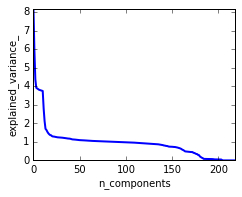

In [77]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [113]:
clf4=LogisticRegression(C=0.0025,penalty='l2',random_state=1, n_jobs=-1)
clf4.fit(Reduced4train,Y)

LogisticRegression(C=0.0025, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [114]:
Y_pred4 = clf4.predict_proba(Reduced4test)[:, 1]

In [115]:
Y_pred4.shape

(17177,)

In [81]:
test['radiant_win']=Y_pred4

In [82]:
test['radiant_win'].to_csv('prediction_result_6.csv')

In [116]:
import mpld3

mpld3.enable_notebook()
fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))

somefig=ax.plot(clf4.coef_[0],'ro-')
#x=range(len(allColumns))
#plt.xticks(clf2.coef_[0],allColumns, rotation='vertical')

#labels = ['point {0}'.format(i + 1) for i in range(N)]
tooltip = mpld3.plugins.PointLabelTooltip(somefig[0], labels=Reduced4testCols)
mpld3.plugins.connect(fig, tooltip)
mpld3.display()

### Добавление полиномиальных характеристик